<a href="https://colab.research.google.com/github/pejmanrasti/From_Shallow_to_Deep/blob/main/2_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
%matplotlib inline

TensorFlow 1.x selected.


# **Make your fist experience with Tensorflow-Keras**
Our goal is to use transfer learning to learn an accurate image classifier from a relatively small number of training samples. Generally speaking, transfer learning refers to the process of leveraging the knowledge learned in one model for the training of another model..

## Loading Training and Validation Data

we use the dataset [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), which contains around 9000 labeled images belonging to 101 object categories. However, we will exclude 5 of the categories which have the most images. This is in order to keep the class distribution fairly balanced (around 50-100) and constrained to a smaller number of images, around 2935.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import os
import cv2
import random
import numpy as np
from sklearn.model_selection import train_test_split

! pip install TensorBoardColab
from tensorflow.keras.models import Sequential,Model # Model type to be used
from tensorflow.keras.layers import Dense, Activation, Dropout# Make Fully connected (FC) layers
from tensorflow.keras.utils import to_categorical # NumPy related tools
from tensorflow.keras.callbacks import TensorBoard  #Visulization of Accuracy and loss
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

  Created wheel for TensorBoardColab: filename=tensorboardcolab-0.0.22-py3-none-any.whl size=3857 sha256=9195962439213f393abc95f0ae1227eaef0e2f9f30c09575efcfdce9431beb4f
  Stored in directory: /root/.cache/pip/wheels/69/4e/4a/1c6c267395cb10edded1050df12af165d3254cfce324e80941
Successfully built TensorBoardColab


Using TensorFlow backend.


In [3]:
from google.colab import drive
root = '/content/gdrive/'
drive.mount( root )

Mounted at /content/gdrive/


In [ ]:
!unzip gdrive/My\ Drive/data_Iran/101_ObjectCategories.zip

In [5]:
DATADIR = "101_ObjectCategories"
CATEGORIES = os.listdir(DATADIR)
print(CATEGORIES)
CATEGORIES = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
print(CATEGORIES)

['mayfly', 'panda', 'hedgehog', 'grand_piano', 'sea_horse', 'anchor', 'butterfly', 'elephant', 'brontosaurus', 'buddha', 'schooner', 'dollar_bill', 'ewer', 'flamingo_head', 'inline_skate', 'laptop', 'barrel', 'sunflower', 'dolphin', 'starfish', 'octopus', 'crocodile_head', 'wrench', 'minaret', 'llama', 'pyramid', 'rhino', 'soccer_ball', 'mandolin', 'Leopards', 'scissors', 'airplanes', 'strawberry', 'wheelchair', 'euphonium', 'pizza', 'Motorbikes', 'windsor_chair', 'ferry', 'umbrella', 'revolver', 'cup', 'electric_guitar', 'rooster', 'menorah', 'yin_yang', 'camera', 'stapler', 'car_side', 'ketch', 'ibis', 'pagoda', 'pigeon', 'wild_cat', 'cougar_body', 'snoopy', 'water_lilly', 'crayfish', 'ant', 'headphone', 'cougar_face', 'lamp', 'joshua_tree', 'ceiling_fan', 'dalmatian', 'chandelier', 'cannon', 'stop_sign', 'platypus', 'watch', 'bonsai', 'dragonfly', 'binocular', 'helicopter', 'garfield', 'chair', 'flamingo', 'accordion', 'gerenuk', 'Faces_easy', 'hawksbill', 'tick', 'lotus', 'emu', 'n

In [6]:
training_data = []
IMG_SIZE_H=224 # you need to set up a numerical value here. Useful to resize to normalize data size
IMG_SIZE_W=224 # you need to set up a numerical value here. Useful to resize to normalize data size
def create_training_data():
    for category in CATEGORIES:  # do plants and weeds

        path = os.path.join(DATADIR,category)  # create path to the labels
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=plants 1=weeds

        for img in os.listdir(path):  # iterate over each image per plants and weeds
          if img.endswith('.jpg'):
            img_array = cv2.imread(os.path.join(path,img))  # convert to array 
            new_array = cv2.resize(img_array, (IMG_SIZE_H, IMG_SIZE_W))  # resize to normalize data size
            training_data.append([new_array, class_num])  # add this to our training_data


In [7]:
create_training_data()  # Calling the function for reading images and labels
print(len(training_data)) # Printing the size of the database

2935


Preparation of data for importing to Keras

In [8]:
random.shuffle(training_data)
X = []  # An Array for images
y = []  # An Array for labels

for features,label in training_data:   # Seperation of iamegs and labels
    X.append(features)
    y.append(label)
print(np.array(X).shape) # Print the size of the database

(2935, 224, 224, 3)


In [9]:
X = np.array(X).reshape(-1, IMG_SIZE_H, IMG_SIZE_W, 3)  # Reshape data in a form that is suitable for keras
print(X.shape) # Print the size of the database

(2935, 224, 224, 3)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

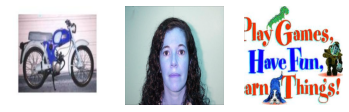

In [12]:
# Display 3 images 
plt.subplot(131)
plt.imshow(X[0,:,:,:])
plt.axis("off")
plt.subplot(132)
plt.imshow(X[10,:,:,:])
plt.axis("off")
plt.subplot(133)
plt.imshow(X[100,:,:,:]) 
plt.axis("off")
# show the plot
plt.show()

# **Importing necessary Libraries**

### First training a neural net from scratch

Before doing the transfer learning, let's first build a neural network from scratch for doing classification on our dataset. This will give us a baseline to compare to our transfer-learned network later.

The network we will construct contains 4 alternating convolutional and max-pooling layers. After the last pooling layer, we will attach a fully-connected layer with 256 neurons then finally a softmax classification layer for our classes.



In [13]:
# normalize data
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [14]:
# build the network
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(5))
model.add(Activation('softmax'))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________

In [15]:
tbcCNN=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://ff45-35-202-157-76.ngrok.io


In [16]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=1, mode='auto') #Stop training when a monitored metric has stopped improving.

checkpoint_filepath = 'checkpointCNN.h5'
Model_check = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto') #Callback to save the Keras model or model weights at some frequency.

In [17]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=50, batch_size=32,
          verbose=1,
          callbacks=[TensorBoardColabCallback(tbcCNN),early_stop, Model_check])

Train on 2054 samples, validate on 881 samples


Epoch 1/50
2048/2054 [============================>.] - ETA: 0s - loss: 0.6728 - acc: 0.7402WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorboardcolab/callbacks.py:51: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.


Epoch 00001: val_loss improved from inf to 0.26249, saving model to checkpointCNN.h5
2054/2054 [==============================] - 11s 6ms/sample - loss: 0.6717 - acc: 0.7405 - val_loss: 0.2625 - val_acc: 0.9092
Epoch 2/50
2048/2054 [============================>.] - ETA: 0s - loss: 0.1941 - acc: 0.9316
Epoch 00002: val_loss improved from 0.26249 to 0.18501, saving model to checkpointCNN.h5
2054/2054 [==============================] - 5s 2ms/sample - loss: 0.1936 - acc: 0.9318 - val_loss: 0.1850 - val_acc: 0.9444
Epoch 3/50
2048/2054 [============================>.] - ETA: 0s - loss: 0.1115 - acc: 0.9639
Epoch 00003: val_loss improved from 0.18501 to 0.13582, saving model to c

**Evaluation and Prediction**

We can use our model to make a prediction on new images.

In [18]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0) #Evaluation of the model on the test dataset
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.15165555163389166
Test accuracy: 0.9614075


Finally, we see that we have achieved a (top-1) accuracy of around 97%. That's not too bad for 2935 images, considering that if we were to use a naive strategy of taking random guesses, we would have only gotten around 1% accuracy. 

## Transfer learning by starting with existing network

Now we can move on to the main strategy for training an image classifier on our small dataset: by starting with a larger and already trained network.

To start, we will load the VGG16 from keras, which was trained on ImageNet and the weights saved online. If this is your first time loading VGG16, you'll need to wait a bit for the weights to download from the web. Once the network is loaded, we can again inspect the layers with the `summary()` method.

In [19]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467904/553467096 [==============================] - 10s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

Notice that VGG16 is _much_ bigger than the network we constructed earlier. It contains 13 convolutional layers and two fully connected layers at the end, and has over 138 million parameters, around 100 times as many parameters than the network we made above. Like our first network, the majority of the parameters are stored in the connections leading into the first fully-connected layer.

VGG16 was made to solve ImageNet, and achieves a [8.8% top-5 error rate](https://github.com/jcjohnson/cnn-benchmarks), which means that 91.2% of test samples were classified correctly within the top 5 predictions for each image.

In order to use this network for our task, we "remove" the final classification layer, the 1000-neuron softmax layer at the end, which corresponds to ImageNet, and instead replace it with a new softmax layer for our dataset, which contains 5 neurons in the case of our dataset. 

In terms of implementation, it's easier to simply create a copy of VGG from its input layer until the second to last layer, and then work with that, rather than modifying the VGG object directly. So technically we never "remove" anything, we just circumvent/ignore it. This can be done in the following way, by using the keras `Model` class to initialize a new model whose input layer is the same as VGG but whose output layer is our new softmax layer, called `new_classification_layer`. Note: although it appears we are duplicating this large network, internally Keras is actually just copying all the layers by reference, and thus we don't need to worry about overloading the memory.

In [20]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(5, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


We are going to retrain this network, `model_new` on our dataset and labels. But first, we need to freeze the weights and biases in all the layers in the network, except our new one at the end, with the expectation that the features that were learned in VGG should still be fairly relevant to the new image classification task. Not optimal, but most likely better than what we can train to in our limited dataset. 

By setting the `trainable` flag in each layer false (except our new classification layer), we ensure all the weights and biases in those layers remain fixed, and we simply train the weights in the one layer at the end. In some cases, it is desirable to *not* freeze all the pre-classification layers. If your dataset has enough samples, and doesn't resemble ImageNet very much, it might be advantageous to fine-tune some of the VGG layers along with the new classifier, or possibly even all of them. To do this, you can change the below code to make more of the layers trainable.

In the case of CalTech-101, we will just do feature extraction, fearing that fine-tuning too much with this dataset may overfit. But maybe we are wrong? A good exercise would be to try out both, and compare the results.

So we go ahead and freeze the layers, and compile the new model with exactly the same optimizer and loss function as in our first network, for the sake of a fair comparison. We then run `summary` again to look at the network's architecture.

In [21]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Looking at the summary, we see the network is identical to the VGG model we instantiated earlier, except the last layer, formerly a 1000-neuron softmax, has been replaced by a new 5-neuron softmax. Additionally, we still have roughly 134 million weights, but now the vast majority of them are "non-trainable params" because we froze the layers they are contained in. We now only have 20,485 trainable parameters, which is actually less than 2% of the number of parameters needed to train the first model.

As before, we go ahead and train the new model, using the same hyperparameters (batch size and number of epochs) as before, along with the same optimization algorithm. We also keep track of its history by tensorboard.

In [22]:
tbcTransfer=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://ff45-35-202-157-76.ngrok.io


In [23]:
checkpoint_filepath_transfer = 'checkpointTransfer.h5'
Model_check_transfer = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath_transfer, monitor='val_loss', verbose=1, save_best_only=True, mode='auto') #Callback to save the Keras model or model weights at some frequency.

In [24]:
model_new.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=100, batch_size=32,
          verbose=1,
          callbacks=[TensorBoardColabCallback(tbcTransfer),early_stop, Model_check_transfer])

Train on 2054 samples, validate on 881 samples
Epoch 1/100
2048/2054 [============================>.] - ETA: 0s - loss: 0.7449 - acc: 0.7783
Epoch 00001: val_loss improved from inf to 0.30916, saving model to checkpointTransfer.h5
2054/2054 [==============================] - 22s 11ms/sample - loss: 0.7439 - acc: 0.7790 - val_loss: 0.3092 - val_acc: 0.9330
Epoch 2/100
2048/2054 [============================>.] - ETA: 0s - loss: 0.2305 - acc: 0.9604
Epoch 00002: val_loss improved from 0.30916 to 0.20489, saving model to checkpointTransfer.h5
2054/2054 [==============================] - 19s 9ms/sample - loss: 0.2309 - acc: 0.9601 - val_loss: 0.2049 - val_acc: 0.9716
Epoch 3/100
2048/2054 [============================>.] - ETA: 0s - loss: 0.1608 - acc: 0.9673
Epoch 00003: val_loss improved from 0.20489 to 0.14355, saving model to checkpointTransfer.h5
2054/2054 [==============================] - 19s 9ms/sample - loss: 0.1605 - acc: 0.9674 - val_loss: 0.1435 - val_acc: 0.9762
Epoch 4/100
20

Our validation accuracy hovers close to 98% towards the end, which is more than 2% improvement on the original network trained from scratch. 


**Evaluation and Prediction**

We can use our model to make a prediction on new images.

In [ ]:
model_New_load = tf.keras.models.load_model('checkpointTransfer.h5')
loss, accuracy = model_New_load.evaluate(X_test, y_test, verbose=0) #Evaluation of the model on the test dataset
print('Test loss:', loss)
print('Test accuracy:', accuracy)